Find a good GAN routine.

In [2]:
import sys
sys.path.append("../mypkg")

In [3]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, moving_average
from utils.colors import qual_cmap
from data_gen import get_simu_data
from models.gan_v4 import Generator, Discriminator
from gan.gan_train2 import MyGAN2
from gan.utils import MyDataSet
from CQR import get_CQR_CIs

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict

In [8]:
np.maximum([1, 3, -1], 2)

array([2, 3, 2])

# GAN

In [5]:
#%matplotlib inline
import random
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)
plt.style.use(FIG_ROOT/"base.mplstyle")

Random Seed:  999


## Data loader

In [6]:
n = 400
d = 10
ntest = 1000
rho = 0.9
nz = 5 
is_homo = False

False

In [7]:
data = get_simu_data(n, d, rho=rho, is_homo=is_homo, is_condition=False);
data_test = get_simu_data(ntest, d, rho=rho, is_homo=is_homo, is_condition=False);

train_data = MyDataSet(Y=data.Y1, X=data.X)
test_data = MyDataSet(Y=data_test.Y1, X=data_test.X)

In [ ]:
my_gan =  MyGAN2(Generator=Generator, Discriminator=Discriminator, nz=nz, verbose=True,
                d=d, train_data=train_data, save_dir="test", prefix="", lr=0.002, batch_size=128);
my_gan.train(num_epochs=1000, data_test=data_test, save_snapshot=100)

In [22]:
netG = my_gan.get_opt_model();
#netG = my_gan.netG;

2023-12-14 13:43:41,550 - gan.gan_train2 - INFO - The window size is 133.
2023-12-14 13:43:41,552 - gan.gan_train2 - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/test/gan_G_epoch200_iter800.pth


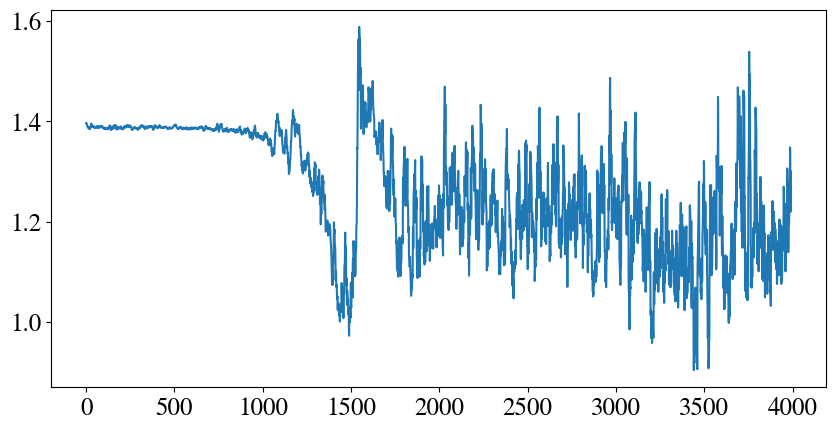

In [23]:
plt.plot(moving_average(my_gan.D_losses, 10))

## Evaluate

In [24]:
#netG = my_gan.get_opt_model();
netG = my_gan.netG;

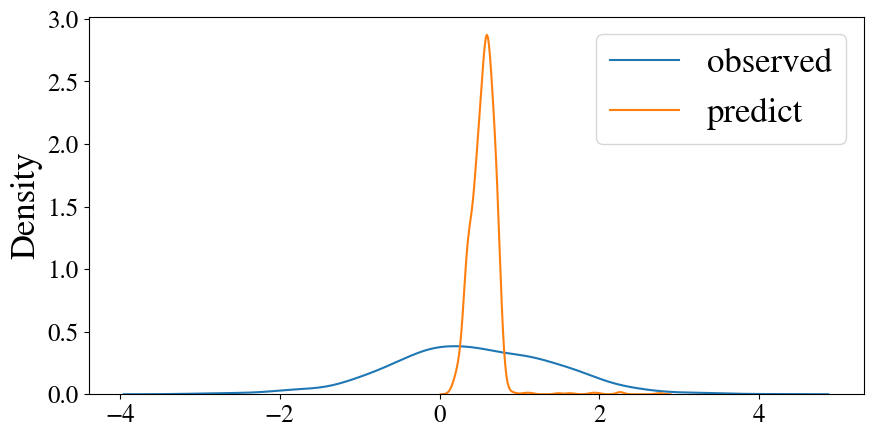

In [29]:
datatest_con = get_simu_data(ntest, d, rho=rho, is_homo=is_homo, is_condition=True);
tX_con = torch.tensor(datatest_con.X)
tZ = torch.randn(ntest, nz);

my_gan.netG.eval()
with torch.no_grad():
    _, tY_con_hat = netG(tX_con, tZ)
    tY_con_hat = tY_con_hat.detach().numpy().reshape(-1);
tY_con_hat.mean()

sns.kdeplot(datatest_con.Y1, label="observed")
sns.kdeplot(tY_con_hat, label="predict")
plt.legend()

(-10.0, 10.0)

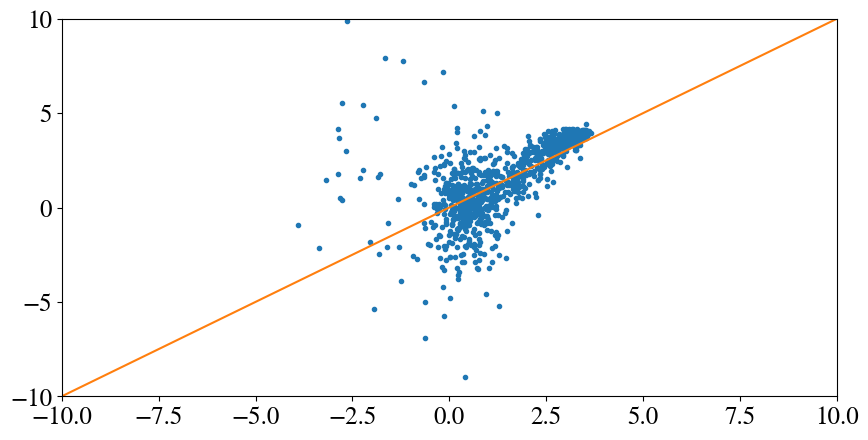

In [30]:
tX = torch.tensor(data_test.X)
tZ = torch.randn(ntest, nz);
my_gan.netG.eval()
with torch.no_grad():
    tY_hat0, tY_hat = netG(tX, tZ)
    tY_hat = tY_hat0.detach().numpy().reshape(-1);
plt.figure(figsize=[10, 5])
plt.plot(tY_hat, data_test.Y1, ".")

xx = np.linspace(-10, 10, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-10, 10])
plt.ylim([-10, 10])